<a href="https://colab.research.google.com/github/MitchellMBurton/Call_Center_Case_Study/blob/main/Call_Center_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Call Center Case Study Simulation

This code creates a simulation of a call center with the goal of determining the number of consultants
required to satisfy two separate key performance indicators (KPIs). KPI-1 is the percentage of sales
calls completed, with the goal of 85%, and KPI-2 is percentage of service calls completed, with the
goal of 50%. The base case is to have 8 consultants answering calls and then to determine what level
of service is provided, from here this number is adjusted to find a new case to use to reach the KPIs.

This code is accompanied by a report which contains the simulation design chart, simulation manual, model validation, KPI
assessment, and comparison of the base case and the adjusted case.


In [ ]:
!pip install simpy

***** REP 1 of 10 *****
KPI 1:  0.8100027181299266
KPI 2:  0.643944218033622
Phone line average use:  0.8338016551059213
Consultant average use:  0.9979823033620502
Consultant average queue:  11.36040182875626
***** REP 2 of 10 *****
KPI 1:  0.8062010267495272
KPI 2:  0.6432578038345745
Phone line average use:  0.8421163175009329
Consultant average use:  0.9989144257312118
Consultant average queue:  11.575509444496138
***** REP 3 of 10 *****
KPI 1:  0.8337919647771052
KPI 2:  0.6732775919732441
Phone line average use:  0.811736338760803
Consultant average use:  0.9979539324797718
Consultant average queue:  10.793688191710327
***** REP 4 of 10 *****
KPI 1:  0.8037128218777031
KPI 2:  0.6372176883659139
Phone line average use:  0.8331913753850274
Consultant average use:  0.9987861442045173
Consultant average queue:  11.326352692975924
***** REP 5 of 10 *****
KPI 1:  0.8060318943084006
KPI 2:  0.6368489213177927
Phone line average use:  0.8451966576188196
Consultant average use:  0.998771

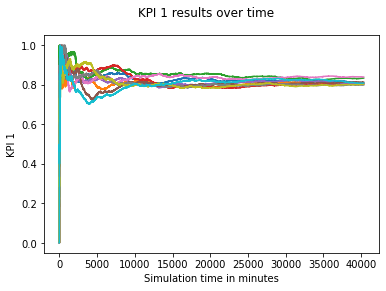

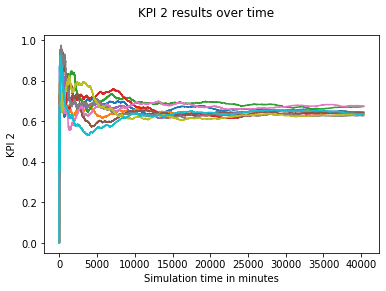

In [ ]:
### Call Centre Case Study
### Mitchell Burton.

# Call center simulation with KPI metrics and steady state graph.

# Import packages
import simpy
import statistics
import random
import matplotlib.pyplot as plt

# Set random seed for testing
# random.seed(12345789)

class Call_Center(object):
  def __init__(self, show_full_output = False):
    #self.env = env
    self.show_full_output = show_full_output
    if show_full_output:
      print('Time, Type, Caller-ID, Status, Phone line')

    # Summary stats
    self.phone_line_use = []
    self.consultant_use = []
    self.consultant_queue = []
    
    # Sales calls statistics
    self.sales_calls_received_to_phone_menu = 0
    self.sales_calls_completed = 0
    self.sales_calls_bounced = 0

    # Service calls statistics
    self.service_calls_received_to_phone_menu = 0
    self.service_calls_completed = 0
    self.service_calls_bounced = 0

    # KPI over time
    self.kpi1 = []
    self.kpi2 = []
    self.kpi_x = []

    # Event types and description
    self.ARRIVE = 0
    self.MENU = 1
    self.QUEUE = 2
    self.LINE_FULL = 3
    self.RENEG = 4
    self.TALK = 5
    self.END = 6
    self.event_types = ["Make phone call", "Enter phone menu", "Queue for consultant", "Phone line full", "Reneg because consultant took to long", "Talk to consultant", "End phone call"]

  # Create notify event method to update stats and print status
  def notify_event(self, env, type, t, caller_id, event_type, phone_line_count):
    # Gather KPI over time data
    # Was having a divide by 0 problem with my random seed in one of the mutliple replication runs so chose a value close to averages for try-except
    if event_type == self.MENU or event_type == self.LINE_FULL or event_type == self.TALK:
      self.kpi_x.append(t)
      try:
        self.kpi1.append(self.sales_calls_completed/(self.sales_calls_bounced + self.sales_calls_received_to_phone_menu))
      except ZeroDivisionError:
        self.kpi1.append(0.82)

      try:
        self.kpi2.append(self.service_calls_completed/(self.service_calls_bounced + self.service_calls_received_to_phone_menu))
      except ZeroDivisionError:
        self.kpi2.append(0.68)

    if self.show_full_output:
      print('%1.2f, %s, %d, %s, %d' % (env.now, type, caller_id, self.event_types[event_type], phone_line_count))

  # Create dislpay summary statistics method
  def display_summary_statistics(self):
    print("KPI 1: ", self.sales_calls_completed/(self.sales_calls_bounced+self.sales_calls_received_to_phone_menu))
    print("KPI 2: ", self.service_calls_completed/(self.service_calls_bounced+self.service_calls_received_to_phone_menu))
    print("Phone line average use: ", statistics.mean(self.phone_line_use)/num_phone_lines)
    print("Consultant average use: ", statistics.mean(self.consultant_use)/num_consultants)
    print("Consultant average queue: ", statistics.mean(self.consultant_queue))

    if self.show_full_output:
      fig, ax = plt.subplots()
      ax.plot(self.kpi1, label = "KPI 1")
      ax.plot(self.kpi2, label = "KPI 2")
      leg = ax.legend(loc = 'lower right')
      plt.show()

# Create call back process
def call_back(env, caller_id, type, call_center, phone_line, consultant, service_call_back_dist, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, priority):
  # Callback time for service
  if type == "service":
    yield env.timeout(random.triangular(*service_call_back_dist))
    env.process(person_calls(env, caller_id, type, call_center, phone_line, consultant, service_call_back_dist, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, priority))
  else:
    yield env.timeout(random.triangular(*sales_call_back_time_dist))
    call_back_odds = random.randint(0,1)
    if call_back_odds > 0.5:
      env.process(person_calls(env, caller_id, type, call_center, phone_line, consultant, service_call_back_dist, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, priority))

# Call process
def person_calls(env, caller_id, type, call_center, phone_line, consultant, service_call_back_dist, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, priority):

  # Customer makes phone call
  # Check if phone line is available
  if phone_line.count < num_phone_lines: # if phone line available the customer goes through call process
    phone_line_count = phone_line.count
    call_center.phone_line_use.append(phone_line_count)
    
    # Arrival
    t = env.now
    call_center.notify_event(env, type, t, caller_id, call_center.ARRIVE, phone_line_count)
    
    # Track call arrivals into phone menu
    if type == "service":
      call_center.service_calls_received_to_phone_menu += 1
    else:
      call_center.sales_calls_received_to_phone_menu += 1 
  
    # Now that caller has a phone line go through the stages of a call
    with phone_line.request() as phone_line_request:
      
      # Caller enters phone menu
      t = env.now
      call_center.notify_event(env, type, t, caller_id, call_center.MENU, phone_line_count)
      yield env.timeout(random.triangular(*phone_menu_dist))
      
      # Request and talk to consultant or reneg
      t = env.now
      call_center.notify_event(env, type, t, caller_id, call_center.QUEUE, phone_line_count)
      # Create reneg time
      reneg_time = random.triangular(*reneg_time_dist)
      # Request consultant and wait - reneg if taking too long
      with consultant.request(priority) as request:
        result = yield request | env.timeout(reneg_time)
        
        if request in result: # If reached consultant...
          t = env.now
          call_center.notify_event(env, type, t, caller_id, call_center.TALK, phone_line_count)
          # Get statistics for validation
          call_center.consultant_use.append(consultant.count)
          call_center.consultant_queue.append(len(consultant.queue))
          # Create consultant call time
          consultant_call_time = random.triangular(*consultation_time_dist)
          yield env.timeout(consultant_call_time)
        else: # If Consultant took to long
          t = env.now
          call_center.notify_event(env, type, t, caller_id, call_center.RENEG, phone_line_count)
          env.process(call_back(env, caller_id, type, call_center, phone_line, consultant, service_call_back_dist, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist,  priority))
          return
      
      # Caller finishes call
      t = env.now
      call_center.notify_event(env, type, t, caller_id, call_center.END, phone_line_count)

      # Track scompleted calls
      if type == "service":
        call_center.service_calls_completed += 1
      else:
        call_center.sales_calls_completed += 1
      
      # Release phone line so another customer can use
      yield phone_line_request

  else: # If phone line not available the customer goes into call-back process
    phone_line_count = phone_line.count
    t = env.now
    call_center.notify_event(env, type, t, caller_id, call_center.LINE_FULL, phone_line_count)
    env.process(call_back(env, caller_id, type, call_center, phone_line, consultant, service_call_back_dist, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist,  priority))
    # Track bounced calls
    if type == "service":
      call_center.service_calls_bounced += 1
    else:
      call_center.sales_calls_bounced += 1

## Arrivals
# Sales arrivals
def calls_arrivals(env, type, call_center, phone_line, consultant, service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, priority):
  caller_id = 0

  while True:
    caller_id += 1
    # Create sales customers
    if type == "sales":
      sales_iat = random.expovariate(sales_arrival_rate)
      yield env.timeout(sales_iat)
      env.process(person_calls(env, caller_id, type, call_center, phone_line, consultant, service_call_back_dist, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, priority))
    # Create service customers
    if type == "service":
      service_iat = random.triangular(*service_arrivals_dist)
      yield env.timeout(service_iat)
      env.process(person_calls(env, caller_id, type, call_center, phone_line, consultant, service_call_back_dist, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, priority))
    
# Create run simulation method
def simulation_run(service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, sim_end, show_full_output):
  env = simpy.Environment()
  call_center = Call_Center(show_full_output)
  consultant = simpy.PriorityResource(env, num_consultants)
  phone_line = simpy.Resource(env, num_phone_lines)

  #env.process(run_call_center(env))
  env.process(calls_arrivals(env, "sales", call_center, phone_line, consultant, service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, priority = 0))
  env.process(calls_arrivals(env, "service", call_center, phone_line, consultant, service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, priority = 1))
  env.run(until = sim_end)
  # Display statistics
  call_center.display_summary_statistics()
  return call_center

# Create warmup experiment method
def warmup_experiment(service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, sim_end, num_replications):
  fig, ax = plt.subplots()
  fig.suptitle('KPI 1 results over time')
  plt.xlabel('Simulation time in minutes')
  plt.ylabel('KPI 1')
  fig, ax2 = plt.subplots()
  fig.suptitle('KPI 2 results over time')
  plt.xlabel('Simulation time in minutes')
  plt.ylabel('KPI 2')

  for rep in range(num_replications):
    print('***** REP', rep + 1, 'of', num_replications, '*****')
    call_center = simulation_run(service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, sim_end, show_full_output = False)
    ax.plot(call_center.kpi_x, call_center.kpi1)
    ax2.plot(call_center.kpi_x, call_center.kpi2)
  plt.show()

# Create batch simulation method
def simulation_reps(service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, sim_end, num_replications):
  repf = open('kpi1_kpi2_averages_reps.csv', 'w')
  for rep in range(num_replications):
    print('***** REP', rep + 1, 'of', num_replications, '*****')
    call_center = simulation_run(service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, sim_end, show_full_output = False)
    repf.write(str(call_center.sales_calls_completed/(call_center.sales_calls_bounced+call_center.sales_calls_received_to_phone_menu)) + ',' + str(call_center.service_calls_completed/(call_center.service_calls_bounced+call_center.service_calls_received_to_phone_menu)) + '\n')
  repf.close()

# Create batch simulation for validation method
def simulation_validate_reps(service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, sim_end, num_replications):
  repf = open('kpi1_kpi2_averages__validate_reps.csv', 'w')
  for rep in range(num_replications):
    print('***** REP', rep + 1, 'of', num_replications, '*****')
    call_center = simulation_run(service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, sim_end, show_full_output = False)
    repf.write(str(call_center.sales_calls_completed/(call_center.sales_calls_bounced+call_center.sales_calls_received_to_phone_menu)) + ',' + str(call_center.service_calls_completed/(call_center.service_calls_bounced+call_center.service_calls_received_to_phone_menu)) + ',' + str(statistics.mean(call_center.phone_line_use)/num_phone_lines)+ ',' + str(statistics.mean(call_center.consultant_use)/num_consultants)+ ',' + str(statistics.mean(call_center.consultant_queue))+'\n')
  repf.close()

## Run simulation
# Set inputs
num_consultants = 8
num_phone_lines = 25
sim_end = 1440*28
num_replications = 10

## Event time distributions & rates
# Service
service_arrivals_dist = [0, 6, 0]
service_call_back_dist = [1, 60, 5]
# Sales
sales_arrival_rate = 1/3
sales_call_back_time_dist = [1, 60, 30]
# General
phone_menu_dist = [0.5, 3, 1]
consultation_time_dist = [5, 15, 10]
reneg_time_dist = [10, 60, 20]

# Choose if printing caller activities 
show_full_output = False

# Run simulation
# simulation_run(service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, sim_end, show_full_output)

# Run warmup experiment
warmup_experiment(service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, sim_end, num_replications)

# Create simulation data for a batch of repetitions
# simulation_reps(service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, sim_end, num_replications)

# Validate
# simulation_validate_reps(service_arrivals_dist, service_call_back_dist, sales_arrival_rate, sales_call_back_time_dist, phone_menu_dist, consultation_time_dist, reneg_time_dist, sim_end, num_replications)
